# Imports

In [3]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Self Attention

In [3]:
L, d_k, d_v = 4,8,8
q = np.random.randn(L,d_k)
k = np.random.randn(L,d_k)
v = np.random.randn(L,d_v)

In [4]:
q

array([[-1.43314657, -0.68958429, -0.86108124,  0.09508489,  1.4236755 ,
        -0.18503826, -2.06543922, -0.72425694],
       [ 0.01381426, -0.05797834,  0.17358011,  0.18137392,  1.40001165,
        -1.11316294,  1.30004025, -1.4833429 ],
       [ 1.2015744 ,  0.88562765, -1.26675785,  1.90983526,  1.51828946,
        -0.6215344 , -0.84381093,  0.27898317],
       [-0.50455575,  2.19433688, -1.04592851, -0.0990632 , -2.91957275,
        -1.24198651, -0.4260315 ,  0.54103664]])

In [5]:
k

array([[-0.89573882,  0.59575872,  0.62932483,  1.3706639 ,  1.99202557,
        -1.81906467,  0.59556153, -1.43379392],
       [ 0.70779064, -0.98869881,  0.46194471,  0.3435982 ,  1.04767303,
        -0.50423831, -0.84448408, -0.33698132],
       [-1.21415259, -0.18845878, -0.56447991, -1.59124802,  0.28647738,
         2.07454014, -0.57179019,  1.48130302],
       [ 0.67573788, -0.20859519, -0.94975811,  0.71722781, -0.29003071,
         1.12675774, -0.71884537, -0.08917012]])

In [6]:
v

array([[-1.05800722, -0.96276342, -0.95349055,  0.0885535 ,  1.96479734,
        -0.71011295,  0.28629564,  1.98846157],
       [ 0.43508605,  0.50894494,  0.26250843,  0.83530551, -0.35779131,
        -0.87981717, -0.59658486,  1.56959687],
       [-0.41695546, -0.52716846, -0.07328311,  0.58373222, -0.25523755,
         2.34150665, -0.25622958,  1.02477756],
       [-0.55918959, -0.07295214,  0.97466163,  0.21109998, -0.05923678,
        -0.62107704, -1.1790067 , -0.12794776]])

In [8]:
q.var(), k.var(), (q @ k.T).var()

(1.3856409547521307, 1.0045444160234271, 13.552189614150734)

as you can see the variance of the matrix-matrix multiplication is much higher than the varaince of each matrix on its own 
so that's why we need to scale the multiplication

In [9]:
scaled = (q @ k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(1.3856409547521307, 1.0045444160234271, 1.6940237017688413)

## Masking

In [10]:
mask = np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [11]:
mask[mask==0] = -np.infty
mask[mask==1] = 0

In [12]:
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [13]:
scaled+mask

array([[ 1.21702355,        -inf,        -inf,        -inf],
       [ 2.83753546,  0.57970533,        -inf,        -inf],
       [ 1.59961718,  0.9081136 , -1.38185007,        -inf],
       [-1.28015972, -1.87344409, -0.50232767, -0.06045517]])

## Softmax

In [31]:
np.sum(scaled,axis=-1,keepdims=True)

array([[ 3.40966096],
       [ 0.68879402],
       [ 2.05966313],
       [-3.71638665]])

In [28]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=-1,keepdims=True)

In [35]:
attention_encoder = softmax(scaled)
attention_encoder

array([[0.34304923, 0.28075445, 0.23207798, 0.14411834],
       [0.87860741, 0.09188227, 0.00806653, 0.02144379],
       [0.48417117, 0.2424838 , 0.02455637, 0.24878865],
       [0.14053935, 0.07764935, 0.30591876, 0.47589254]])

In [36]:
attention_decoder = softmax(scaled+mask)
attention_decoder

array([[1.        , 0.        , 0.        , 0.        ],
       [0.90532381, 0.09467619, 0.        , 0.        ],
       [0.64452058, 0.32279039, 0.03268903, 0.        ],
       [0.14053935, 0.07764935, 0.30591876, 0.47589254]])

In [37]:
self_attention = attention_decoder @ v
self_attention

array([[-1.05800722, -0.96276342, -0.95349055,  0.0885535 ,  1.96479734,
        -0.71011295,  0.28629564,  1.98846157],
       [-0.91664684, -0.82342767, -0.8383644 ,  0.15925314,  1.74490349,
        -0.7261799 ,  0.20270788,  1.94880505],
       [-0.5550957 , -0.47347093, -0.53220464,  0.34578479,  1.14251726,
        -0.66513736, -0.01642433,  1.82175417],
       [-0.50857615, -0.291775  ,  0.32779619,  0.35634172,  0.14207678,
         0.25262883, -0.64555455,  0.65394457]])

## Let's pipeline it into a function

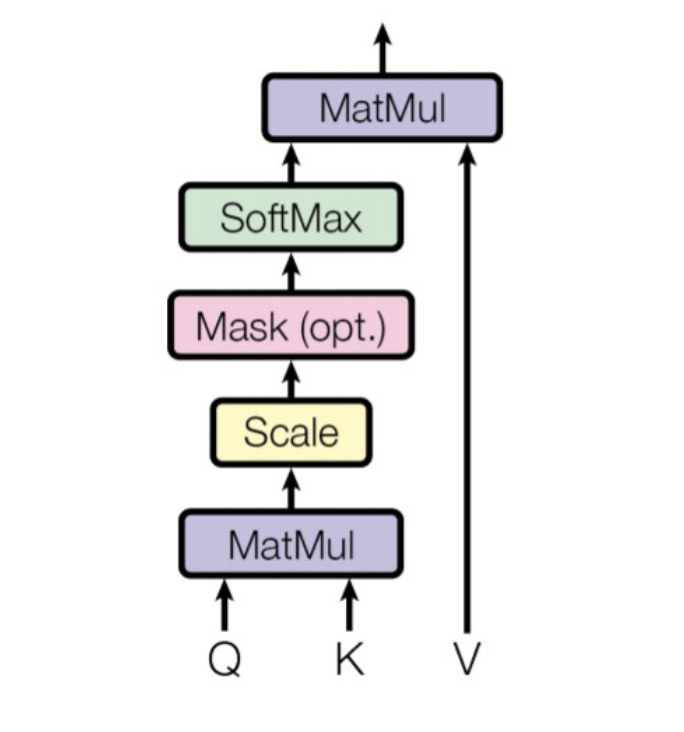

In [46]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=-1,keepdims=True)

def scaled_dot_product_attention(q,k,v,mask=False):
    L,d_k = k.shape
    scaled = (q @ k.T) / math.sqrt(d_k)
    if mask:
        mask_mat = np.tril(np.ones((L,L)))
        mask_mat[mask_mat==0] = -np.infty
        mask_mat[mask_mat==1] = 0
        scaled += mask_mat
    return softmax(scaled) @ v

In [47]:
self_attention_func_encoder = scaled_dot_product_attention(q,k,v)
self_attention_func_encoder

array([[-0.41815188, -0.32024463, -0.12993457,  0.43078872,  0.50579859,
        -0.03671273, -0.29866209,  1.3422002 ],
       [-0.90495082, -0.80494485, -0.7933147 ,  0.163789  ,  1.69008169,
        -0.69918051,  0.16937664,  1.8968179 ],
       [-0.55611421, -0.3738264 , -0.15731342,  0.31227673,  0.84353449,
        -0.65417565, -0.30566163,  1.33669046],
       [-0.50857615, -0.291775  ,  0.32779619,  0.35634172,  0.14207678,
         0.25262883, -0.64555455,  0.65394457]])

In [48]:
self_attention_func_encoder == attention_encoder @ v

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [49]:
self_attention_func_decoder = scaled_dot_product_attention(q,k,v,mask=True)
self_attention_func_decoder

array([[-1.05800722, -0.96276342, -0.95349055,  0.0885535 ,  1.96479734,
        -0.71011295,  0.28629564,  1.98846157],
       [-0.91664684, -0.82342767, -0.8383644 ,  0.15925314,  1.74490349,
        -0.7261799 ,  0.20270788,  1.94880505],
       [-0.5550957 , -0.47347093, -0.53220464,  0.34578479,  1.14251726,
        -0.66513736, -0.01642433,  1.82175417],
       [-0.50857615, -0.291775  ,  0.32779619,  0.35634172,  0.14207678,
         0.25262883, -0.64555455,  0.65394457]])

In [50]:
self_attention_func_decoder == attention_decoder @ v

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

# Multi-Head Attention

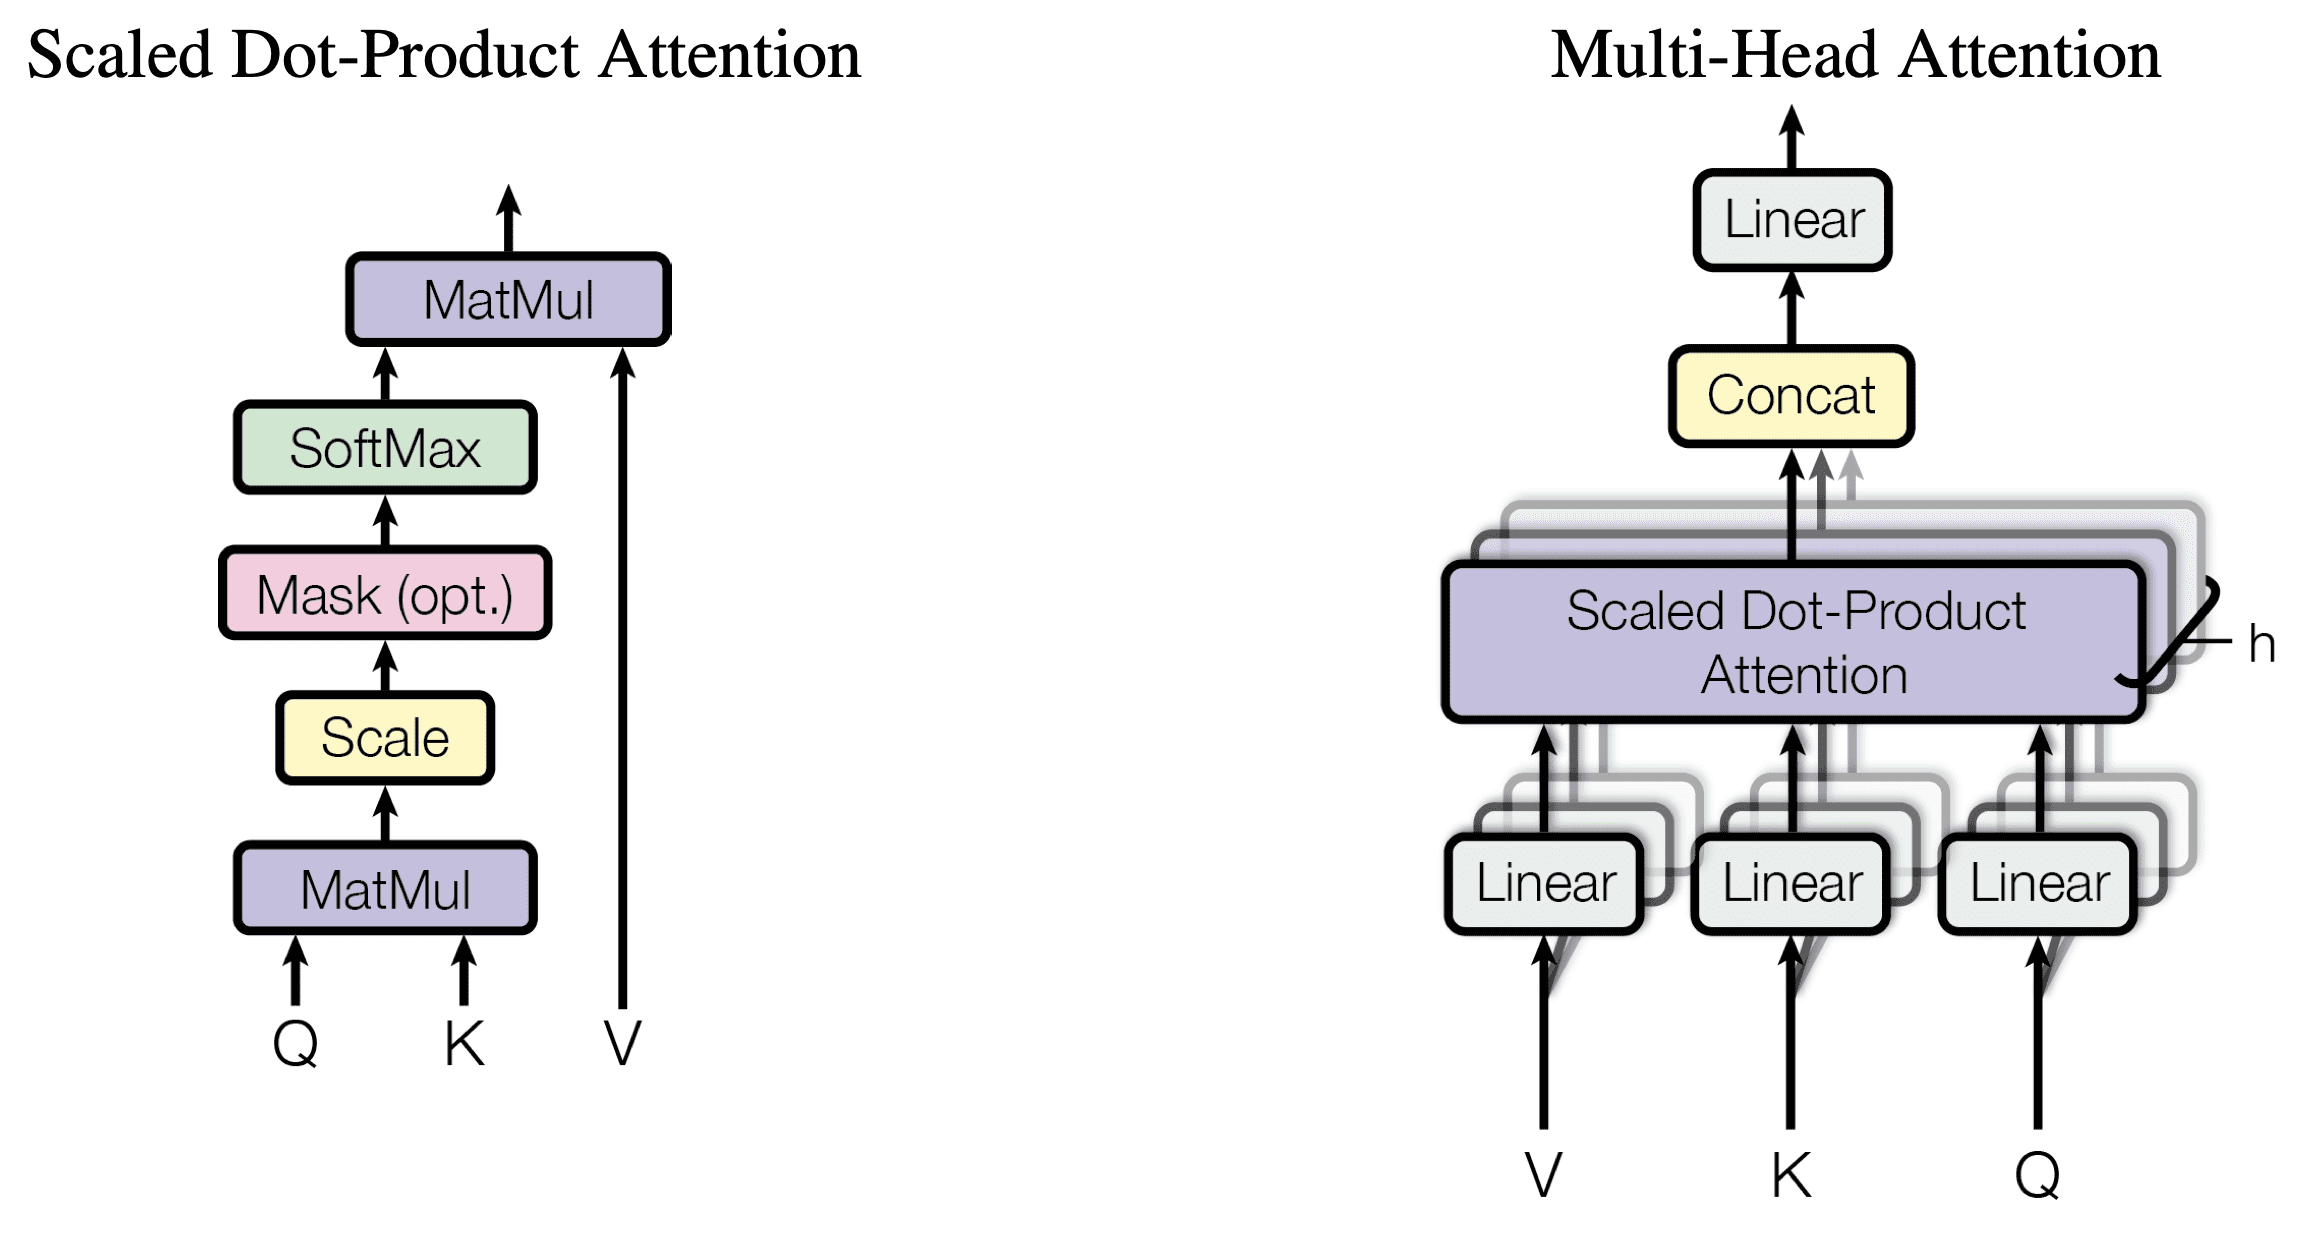

In [8]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [9]:
x

tensor([[[-0.0077,  0.5975, -0.4244,  ..., -1.5624, -0.7537, -0.4539],
         [ 1.0519,  1.9098, -0.9005,  ...,  1.0319,  0.1785, -0.2727],
         [ 0.1990,  0.5178, -0.7520,  ...,  1.2677, -1.2232,  0.9385],
         [ 1.2867, -0.1860, -0.7186,  ..., -0.2826,  0.1837,  0.4568]]])

In [10]:
x.size()

torch.Size([1, 4, 512])

In [12]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [13]:
qkv = qkv_layer(x)
qkv.size()

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

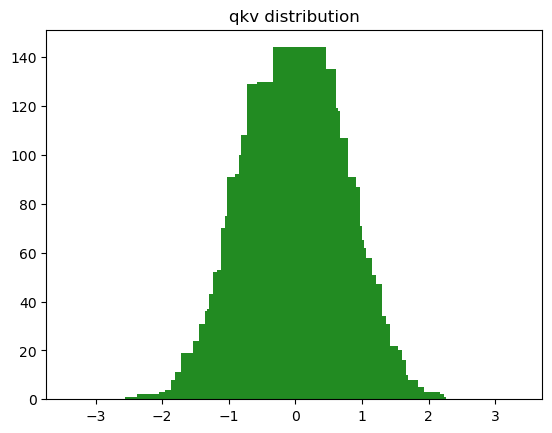

In [15]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [16]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length,num_heads,3*head_dim)

In [17]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [20]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [21]:
q,k,v = qkv.chunk(3,dim=-1)

In [22]:
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for Single Head (using pytorch)

In [23]:
d_k = k.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [27]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [28]:
k.transpose(-2,-1).shape

torch.Size([1, 8, 64, 4])

In [29]:
k.transpose(-2,-1) == k.transpose(-1,-2)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [30]:
mask = torch.full(scaled.shape,fill_value=float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask

tensor([[[[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0.,

In [31]:
scaled + mask

tensor([[[[ 0.3352,    -inf,    -inf,    -inf],
          [ 0.2949, -0.0765,    -inf,    -inf],
          [ 0.0326, -0.0060,  0.2379,    -inf],
          [ 0.0327, -0.2723, -0.4304,  0.0846]],

         [[-0.2519,    -inf,    -inf,    -inf],
          [ 0.4076, -0.0724,    -inf,    -inf],
          [-0.0608,  0.4162,  0.0704,    -inf],
          [-0.0329, -0.5322, -0.1339, -0.0871]],

         [[ 0.2288,    -inf,    -inf,    -inf],
          [ 0.2440,  0.1297,    -inf,    -inf],
          [ 0.1841, -0.2532, -0.0924,    -inf],
          [-0.0822, -0.3028,  0.1303, -0.4170]],

         [[ 0.6114,    -inf,    -inf,    -inf],
          [-0.6117,  0.2197,    -inf,    -inf],
          [-0.2049, -0.5968,  0.1663,    -inf],
          [ 0.7413,  0.0956, -0.1197,  0.0484]],

         [[ 0.1809,    -inf,    -inf,    -inf],
          [-0.1189, -0.3680,    -inf,    -inf],
          [-0.0846, -0.3933, -0.5546,    -inf],
          [ 0.1602, -0.4647,  0.2485,  0.0735]],

         [[-0.2493,    -inf,  

In [32]:
F.softmax(scaled+mask,dim=-1)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5918, 0.4082, 0.0000, 0.0000],
          [0.3135, 0.3016, 0.3849, 0.0000],
          [0.2924, 0.2155, 0.1840, 0.3080]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6177, 0.3823, 0.0000, 0.0000],
          [0.2666, 0.4295, 0.3039, 0.0000],
          [0.2892, 0.1755, 0.2614, 0.2739]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5285, 0.4715, 0.0000, 0.0000],
          [0.4159, 0.2686, 0.3155, 0.0000],
          [0.2664, 0.2136, 0.3294, 0.1906]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.3034, 0.6966, 0.0000, 0.0000],
          [0.3200, 0.2162, 0.4638, 0.0000],
          [0.4086, 0.2142, 0.1727, 0.2044]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5620, 0.4380, 0.0000, 0.0000],
          [0.4238, 0.3113, 0.2649, 0.0000],
          [0.2821, 0.1510, 0.3082, 0.2587]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.3385, 0.6615, 0.0000, 0.0000],
          [0.2701, 0.4

### Make it a Function

In [33]:
def scaled_dot_product(q, k, v, mask=False):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask:
        mask_mat = torch.full(scaled.shape,fill_value=float('-inf'))
        mask_mat = torch.triu(mask_mat,diagonal=1)
        scaled += mask_mat
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [34]:
values, attention = scaled_dot_product(q, k, v, mask=True)

In [35]:
attention.shape

torch.Size([1, 8, 4, 4])

In [36]:
values.shape

torch.Size([1, 8, 4, 64])

In [37]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.shape

torch.Size([1, 4, 512])

In [38]:
linear_layer = nn.Linear(d_model, d_model)

In [39]:
out = linear_layer(values)

In [40]:
out.shape

torch.Size([1, 4, 512])

## Multi-head Attention Class

In [46]:
class MultiheadAttention(nn.Module):
    
    def __init__(self,input_dim,d_model,num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def scaled_dot_product(self,q,k,v,mask=False):
        return scaled_dot_product(q, k, v, mask)
    
    def forward(self,x,mask=False):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = self.scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [47]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [48]:
out_mask = model.forward(x,mask=True)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


# Positional Encodings

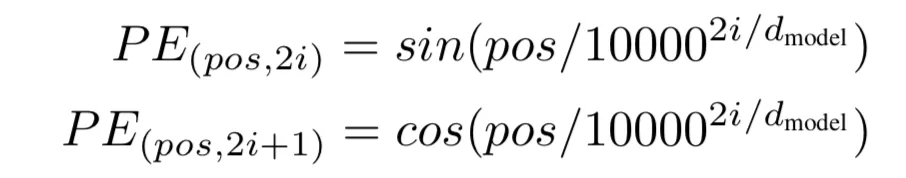

In [3]:
max_sequence_length = 10
d_model = 6

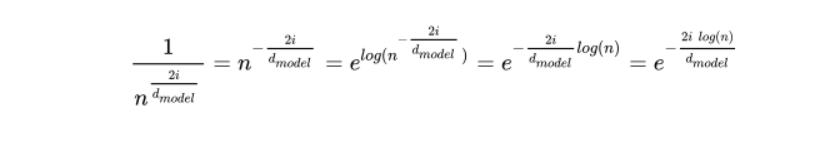

In [37]:
n = 10000
i = torch.arange(0,d_model,2)
div_term = torch.exp(i*-(math.log(n)/d_model))

In [38]:
i

tensor([0, 2, 4])

In [39]:
div_term

tensor([1.0000, 0.0464, 0.0022])

In [40]:
positions = torch.arange(0,max_sequence_length).unsqueeze(1)
positions

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [41]:
pos_embeddings = torch.zeros(max_sequence_length,d_model)
pos_embeddings

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [42]:
pos_embeddings[:,0::2] = torch.sin(positions*div_term)
pos_embeddings[:,1::2] = torch.cos(positions*div_term)

In [43]:
pos_embeddings.shape

torch.Size([10, 6])

In [44]:
pos_embeddings.unsqueeze(0).shape

torch.Size([1, 10, 6])

In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_length: int = 5000, n: int = 10000):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length
        self.n = n
    def forward(self):
        pe = torch.zeros(self.max_length, self.d_model)    
        k = torch.arange(0, self.max_length).unsqueeze(1)  
        div_term = torch.exp(                                 
                torch.arange(0, d_model, 2) * -(math.log(self.n) / d_model)
        )
        pe[:, 0::2] = torch.sin(k * div_term)    
        pe[:, 1::2] = torch.cos(k * div_term)  
        pe = pe.unsqueeze(0)
        return pe

In [55]:
pe = PositionalEncoding(d_model,max_sequence_length)
pos_emb = pe.forward()

In [56]:
pos_emb == pos_embeddings

tensor([[[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]]])

## Another Implementation

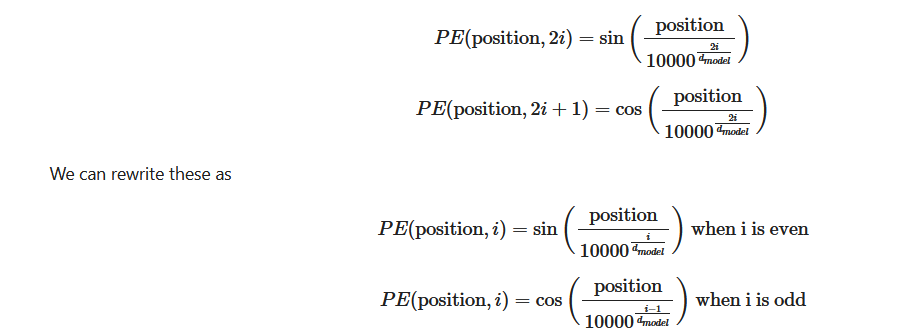

In [63]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        # stacked = torch.stack([even_PE, odd_PE], dim=2)
        # PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        PE = torch.zeros(self.max_sequence_length,self.d_model)
        PE[:,0::2] = even_PE
        PE[:,1::2] = odd_PE
        return PE

In [64]:
pe_2 = PositionalEncoding(d_model,max_sequence_length)
pos_emb_2 = pe_2.forward()

In [65]:
pos_emb_2 == pos_embeddings

tensor([[ True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False, False, False,  True],
        [ True,  True, False,  True, False,  True],
        [ True,  True, False,  True, False,  True]])

# Layer Normalization

Layer Normalization is basically calculating the mean and std of all activation outputs of one layer across one instance
and then normalizing each instance with the corresponding mean and std. In the implementation below, we will make layer norm dynamic in a way in which we can decide across which dimensions we want to normalize

In [69]:
inputs_1 = torch.Tensor([[[0.2, 0.1, 0.3], [0.5, 0.1, 0.1]]])
B, S, E = inputs_1.size()

In [70]:
inputs = inputs_1.reshape(S, B, E)
inputs.size()

torch.Size([2, 1, 3])

In [71]:
inputs

tensor([[[0.2000, 0.1000, 0.3000]],

        [[0.5000, 0.1000, 0.1000]]])

In [72]:
parameter_shape = inputs.size()[-1:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta =  nn.Parameter(torch.zeros(parameter_shape))
gamma.size(), beta.size()

(torch.Size([3]), torch.Size([3]))

In [73]:
dims = [-(i+1) for i in range(len(parameter_shape))]

In [74]:
dims

[-1]

In [75]:
mean = inputs.mean(dim=dims, keepdim=True)
mean.size()

torch.Size([2, 1, 1])

In [76]:
mean

tensor([[[0.2000]],

        [[0.2333]]])

In [77]:
var = ((inputs-mean)**2).mean(dim=dims,keepdim=True)

In [78]:
var.size()

torch.Size([2, 1, 1])

In [79]:
var

tensor([[[0.0067]],

        [[0.0356]]])

In [80]:
epsilon = 1e-5
std = (var+epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.1886]]])

In [81]:
y = (inputs-mean)/std
y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

In [82]:
out = gamma * y + beta

In [83]:
out

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)

## Layer Normalization Class

In [38]:
class LayerNormalization(nn.Module):
    def __init__(self,parameters_shape,eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps=eps
        self.parameters_shape=parameters_shape
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self,inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean \n ({mean.size()}): \n {mean}")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation \n ({std.size()}): \n {std}")
        y = (inputs - mean) / std
        print(f"y \n ({y.size()}) = \n {y}")
        out = self.gamma * y  + self.beta
        print(f"out \n ({out.size()}) = \n {out}")
        return out

In [39]:
batch_size = 3
sentence_length = 5
embedding_dim = 8 
inputs = torch.randn(sentence_length, batch_size, embedding_dim)

print(f"input \n ({inputs.size()}) = \n {inputs}")

input 
 (torch.Size([5, 3, 8])) = 
 tensor([[[-0.7100,  0.2538,  0.7301, -2.0544,  0.4547, -0.7299, -0.1262,
           0.3519],
         [-3.1677,  1.6223, -1.8085, -0.8527,  0.7174, -0.3663,  2.8794,
           0.8043],
         [ 0.1452, -0.0569, -1.6452,  0.6551,  0.8069, -0.1699, -0.9512,
          -1.2069]],

        [[ 0.9344,  0.1260,  0.4074, -0.8670, -0.2895,  0.4184, -1.6341,
          -0.0861],
         [ 0.1053,  1.2762, -0.0686,  1.4383, -1.4956, -0.4915, -1.1085,
          -0.3498],
         [-1.4508,  0.7378, -0.7719,  0.3814, -1.3416, -0.5215, -0.0809,
           1.4577]],

        [[ 0.7991,  0.7250, -0.2962, -0.6260, -0.0722,  0.4437,  0.2979,
          -2.6607],
         [ 0.7594,  2.7312,  1.5323,  1.3906, -1.5523,  0.9738,  0.3633,
           1.1002],
         [ 1.6177, -0.4389, -1.0715,  0.0737,  0.7714,  0.2257,  0.9162,
           0.2753]],

        [[-0.0942,  1.3633, -0.4212, -0.6797, -0.6118, -1.0897,  0.5516,
           1.1202],
         [-0.9212, -0.4086, 

In [40]:
inputs.size()[-1:]

torch.Size([8])

In [41]:
layer_norm = LayerNormalization(inputs.size()[-1:])

In [42]:
out = layer_norm.forward(inputs)

Mean 
 (torch.Size([5, 3, 1])): 
 tensor([[[-0.2288],
         [-0.0215],
         [-0.3029]],

        [[-0.1238],
         [-0.0868],
         [-0.1987]],

        [[-0.1737],
         [ 0.9123],
         [ 0.2962]],

        [[ 0.0173],
         [-0.2171],
         [-0.5293]],

        [[ 0.2191],
         [-0.4474],
         [-0.2886]]])
Standard Deviation 
 (torch.Size([5, 3, 1])): 
 tensor([[[0.8502],
         [1.8113],
         [0.8267]],

        [[0.7600],
         [0.9671],
         [0.9538]],

        [[1.0472],
         [1.1380],
         [0.7764]],

        [[0.8386],
         [0.7222],
         [1.0254]],

        [[0.9114],
         [1.0854],
         [1.0992]]])
y 
 (torch.Size([5, 3, 8])) = 
 tensor([[[-0.5660,  0.5675,  1.1278, -2.1473,  0.8039, -0.5895,  0.1206,
           0.6830],
         [-1.7370,  0.9075, -0.9866, -0.4589,  0.4079, -0.1904,  1.6015,
           0.4559],
         [ 0.5420,  0.2975, -1.6236,  1.1587,  1.3423,  0.1608, -0.7842,
          -1.0936]],



# Encoder

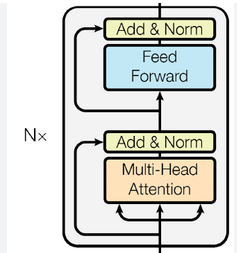

Let's add the above classes again in the cell below

In [12]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

In [17]:
# assume values above

def scaled_dot_product(q, k, v, mask=False):
    # input = 30 x 8 x 200 x 64 each
    d_k = q.size()[-1] # 64
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    if mask:
        mask_mat = torch.full(scaled.shape,fill_value=float('-inf')) # 30 x 8 x 200 x 200
        mask_mat = torch.triu(mask_mat,diagonal=1) # 30 x 8 x 200 x 200
        scaled += mask_mat # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention

class MultiheadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super(MultiheadAttention,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def scaled_dot_product(self,q,k,v,mask=False):
        return scaled_dot_product(q, k, v, mask)
    
    def forward(self,x,mask=False):
        batch_size, sequence_length, input_dim = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x) # 30 x 200 x (3*512=1536)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x (3*64=192)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 192
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1) # each one of q,k,v has shape 30 x 8 x 200 x 64
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = self.scaled_dot_product(q, k, v, mask) # values = 30 x 8 x 200 x 64, attention = 30 x 8 x 200 x 200
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x (8*64=512)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values) # 30 x 200 x 512 (more context aware)
        print(f"out.size(): {out.size()}")
        return out

class LayerNormalization(nn.Module):
    def __init__(self,parameters_shape,eps=1e-5):
        super(LayerNormalization,self).__init__()
        self.eps=eps
        self.parameters_shape=parameters_shape
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # [512]
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # [512]

    def forward(self,inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True) # 30 x 200 x 1
        print(f"Mean \n ({mean.size()}): \n {mean}")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 1
        std = (var + self.eps).sqrt() # 30 x 200 x 1
        print(f"Standard Deviation \n ({std.size()}): \n {std}")
        y = (inputs - mean) / std # 30 x 200 x 1
        print(f"y \n ({y.size()}) = \n {y}")
        out = self.gamma * y  + self.beta # 30 x 200 x 512
        print(f"out \n ({out.size()}) = \n {out}")
        return out

class PositionwiseFeedForward(nn.Module):
    def __init__(self,ffn_hidden,d_model):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model,ffn_hidden)
        self.linear2 = nn.Linear(ffn_hidden,d_model)
        self.dropout = nn.Dropout(p=drop_prob)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.linear1(x) # 30 x 200 x 2048
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x) # 30 x 200 x 2048
        print(f"x after activation: {x.size()}")
        x = self.dropout(x) # 30 x 200 x 2048
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x) # 30 x 200 x 512
        print(f"x after 2nd linear layer: {x.size()}")
        return x

class EncoderLayer(nn.Module):
    def __init__(self,d_model,num_heads, drop_prob, ffn_hidden):
        super(EncoderLayer,self).__init__()
        self.multihead_attention = MultiheadAttention(d_model=d_model,num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(ffn_hidden=ffn_hidden,d_model=d_model)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self,x):
        residual_x = x # 30 x 200 x 512
        print("------- ATTENTION 1 ------")
        x = self.multihead_attention(x, mask=False) # 30 x 200 x 512
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x) # 30 x 200 x 512
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x) # 30 x 200 x 512
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x) # 30 x 200 x 512
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x) # 30 x 200 x 512
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x) # 30 x 200 x 512
        return x


class Encoder(nn.Module):
    def __init__(self,d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super(Encoder,self).__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model,num_heads, drop_prob, ffn_hidden) for _ in range(num_layers)])

    def forward(self,x):
        x = self.layers(x)
        return x
        

In [14]:
encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [15]:
x = torch.randn( (batch_size, max_sequence_length, d_model) ) # assume it includes positional encoding
out = encoder(x)

------- ATTENTION 1 ------
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size(): torch.Size([30, 200, 8, 192])
qkv.size(): torch.Size([30, 8, 200, 192])
q size: torch.Size([30, 8, 200, 64]), k size: torch.Size([30, 8, 200, 64]), v size: torch.Size([30, 8, 200, 64]), 
values.size(): torch.Size([30, 8, 200, 64]), attention.size:torch.Size([30, 8, 200, 200]) 
values.size(): torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean 
 (torch.Size([30, 200, 1])): 
 tensor([[[-0.0115],
         [-0.0269],
         [-0.0068],
         ...,
         [ 0.0057],
         [-0.0754],
         [ 0.0051]],

        [[ 0.0959],
         [-0.0809],
         [ 0.0009],
         ...,
         [-0.0799],
         [ 0.0265],
         [-0.0430]],

        [[-0.0224],
         [-0.0822],
         [-0.0507],
         ...,
         [-0.0455],
         [ 0.0421],
         [ 0.1044]],

        ..

# Decoder

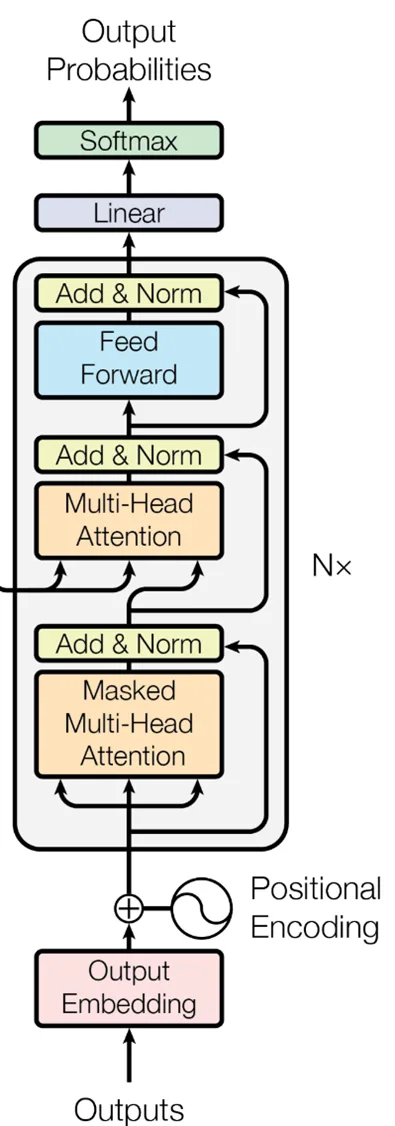

In [25]:
x = torch.randn(30,200,512)
y = torch.randn(30,200,1024)
z = torch.cat((x,y),2)

In [26]:
z.shape

torch.Size([30, 200, 1536])

In [28]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

In [35]:
# assume values above

def scaled_dot_product(q, k, v, mask=False):
    # input = 30 x 8 x 200 x 64 each
    d_k = q.size()[-1] # 64
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    if mask:
        mask_mat = torch.full(scaled.shape,fill_value=float('-inf')) # 30 x 8 x 200 x 200
        mask_mat = torch.triu(mask_mat,diagonal=1) # 30 x 8 x 200 x 200
        scaled += mask_mat # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention

class MultiheadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super(MultiheadAttention,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def scaled_dot_product(self,q,k,v,mask=False):
        return scaled_dot_product(q, k, v, mask)
    
    def forward(self,x,mask=False):
        batch_size, sequence_length, input_dim = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x) # 30 x 200 x (3*512=1536)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x (3*64=192)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 192
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1) # each one of q,k,v has shape 30 x 8 x 200 x 64
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = self.scaled_dot_product(q, k, v, mask) # values = 30 x 8 x 200 x 64, attention = 30 x 8 x 200 x 200
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x (8*64=512)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values) # 30 x 200 x 512 (more context aware)
        print(f"out.size(): {out.size()}")
        return out


class MultiheadCrossAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super(MultiheadCrossAttention,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model, d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def scaled_dot_product(self,q,k,v,mask=False):
        return scaled_dot_product(q, k, v, mask)
    
    def forward(self,x,encoder_values,mask=False):
        batch_size, sequence_length, input_dim = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        q = self.q_layer(x) # 30 x 200 x 512
        print(f"q.size(): {q.size()}")
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) # 30 x 200 x 8 x 64
        print(f"q.size(): {q.size()}")
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        print(f"q.size(): {q.size()}")
        kv = self.kv_layer(encoder_values) # 30 x 200 x (2*512=1024)
        print(f"kv.size(): {kv.size()}")
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim) # 30 x 200 x 8 x (2*64=128)
        print(f"kv.size(): {kv.size()}")
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        print(f"kv.size(): {kv.size()}")
        k, v = kv.chunk(2, dim=-1) # each one of k,v has shape 30 x 8 x 200 x 64
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = self.scaled_dot_product(q, k, v, mask) # values = 30 x 8 x 200 x 64, attention = 30 x 8 x 200 x 200
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x (8*64=512)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values) # 30 x 200 x 512 (more context aware)
        print(f"out.size(): {out.size()}")
        return out


class LayerNormalization(nn.Module):
    def __init__(self,parameters_shape,eps=1e-5):
        super(LayerNormalization,self).__init__()
        self.eps=eps
        self.parameters_shape=parameters_shape
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # [512]
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # [512]

    def forward(self,inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True) # 30 x 200 x 1
        print(f"Mean \n ({mean.size()}): \n {mean}")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 1
        std = (var + self.eps).sqrt() # 30 x 200 x 1
        print(f"Standard Deviation \n ({std.size()}): \n {std}")
        y = (inputs - mean) / std # 30 x 200 x 1
        print(f"y \n ({y.size()}) = \n {y}")
        out = self.gamma * y  + self.beta # 30 x 200 x 512
        print(f"out \n ({out.size()}) = \n {out}")
        return out

class PositionwiseFeedForward(nn.Module):
    def __init__(self,ffn_hidden,d_model):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model,ffn_hidden)
        self.linear2 = nn.Linear(ffn_hidden,d_model)
        self.dropout = nn.Dropout(p=drop_prob)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.linear1(x) # 30 x 200 x 2048
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x) # 30 x 200 x 2048
        print(f"x after activation: {x.size()}")
        x = self.dropout(x) # 30 x 200 x 2048
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x) # 30 x 200 x 512
        print(f"x after 2nd linear layer: {x.size()}")
        return x

class DecoderLayer(nn.Module):
    def __init__(self,d_model,num_heads, drop_prob, ffn_hidden):
        super(DecoderLayer,self).__init__()
        self.masked_multihead_attention = MultiheadAttention(d_model=d_model,num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.multihead_cross_attention = MultiheadCrossAttention(d_model=d_model,num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(ffn_hidden=ffn_hidden,d_model=d_model)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self,x, encoder_values):
        _residual_x = x # 30 x 200 x 512
        print("------- ATTENTION 1 ------")
        x = self.masked_multihead_attention(x, mask=True) # 30 x 200 x 512
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x) # 30 x 200 x 512
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + _residual_x) # 30 x 200 x 512
        
        _residual_x = x  #30 x 200 x 512
        print("------- ATTENTION 2 ------")
        x = self.multihead_cross_attention(x,encoder_values, mask=False)  #30 x 200 x 512
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x) # 30 x 200 x 512
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + _residual_x) # 30 x 200 x 512
        
        _residual_x = x  #30 x 200 x 512
        print("------- Feed Forward ------")
        x = self.ffn(x) # 30 x 200 x 512
        print("------- DROPOUT 3 ------")
        x = self.dropout3(x) # 30 x 200 x 512
        print("------- ADD AND LAYER NORMALIZATION 3 ------")
        x = self.norm3(x + _residual_x) # 30 x 200 x 512
        return x

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x,encoder_values = inputs
        for module in self._modules.values():
            y = module(x, encoder_values) #30 x 200 x 512
        return y 

class Decoder(nn.Module):
    def __init__(self,d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super(Decoder,self).__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model,num_heads, drop_prob, ffn_hidden) for _ in range(num_layers)])

    def forward(self,x,encoder_values):
        #x : 30 x 200 x 512 
        #encoder_values : 30 x 200 x 512
        x = self.layers(x,encoder_values)
        return x
        

In [36]:
encoder_values = torch.randn( (batch_size, max_sequence_length, d_model) ) # English sentence positional encoded 
x = torch.randn( (batch_size, max_sequence_length, d_model) ) # Kannada sentence positional encoded 
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
out = decoder(x, encoder_values)

------- ATTENTION 1 ------
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size(): torch.Size([30, 200, 8, 192])
qkv.size(): torch.Size([30, 8, 200, 192])
q size: torch.Size([30, 8, 200, 64]), k size: torch.Size([30, 8, 200, 64]), v size: torch.Size([30, 8, 200, 64]), 
values.size(): torch.Size([30, 8, 200, 64]), attention.size:torch.Size([30, 8, 200, 200]) 
values.size(): torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean 
 (torch.Size([30, 200, 1])): 
 tensor([[[ 0.0388],
         [ 0.0604],
         [-0.0673],
         ...,
         [-0.0652],
         [ 0.0522],
         [-0.0473]],

        [[-0.0107],
         [-0.0147],
         [-0.0372],
         ...,
         [-0.0280],
         [-0.0531],
         [ 0.0054]],

        [[ 0.0660],
         [ 0.0427],
         [-0.0352],
         ...,
         [ 0.0217],
         [-0.0637],
         [ 0.0456]],

        ..